# 신용카드 부정 사용자 검출
- 신용카드 사기 검출 분류 실습용 데이터
- 데이터에 class 컬럼이 사기 유무를 의미
- class 컬럼의 불균형이 극심해서 전체 데이터 중 약 0.172%만 사기(=1) 을 가짐
- 기업의 기밀 보호를 위해 대다수 컬럼의 이름은 삭제됨
    - Amount : 거래금액
    - Class : Fraud 유무 (1이면 Fraud)

---
# 1. 데이터 불러오기

In [36]:
import pandas as pd

data_path = '../data/creditcard.csv'
raw_data = pd.read_csv(data_path)
raw_data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [37]:
raw_data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [38]:
fraud_rate = round((raw_data['Class'].value_counts()[1] / len(raw_data) )* 100 , 5)
print('Frauds', fraud_rate, '% of the dataset')

Frauds 0.17275 % of the dataset


- 데이터 라벨의 불균형이 매우 심함

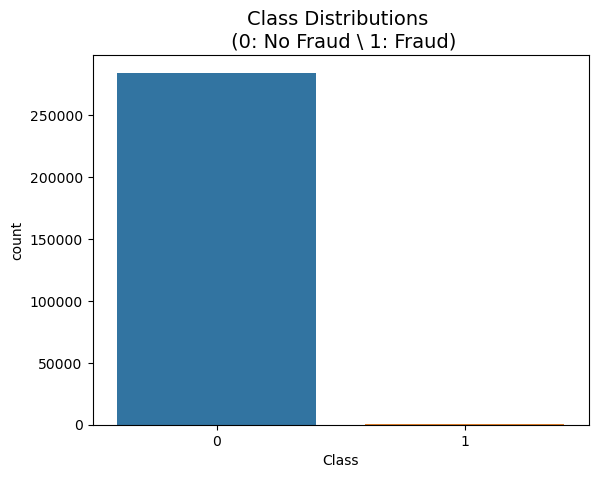

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='Class', data=raw_data)
plt.title('Class Distributions \n (0: No Fraud \\ 1: Fraud)', fontsize=14)
plt.show();

---
# 2. 데이터 나누기

In [40]:
X = raw_data.iloc[:, 1:-1]
y = raw_data.iloc[:, -1]

X.shape, y.shape

((284807, 29), (284807,))

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13, stratify=y)

- stratify 로 불균형성 따라가주기

### 나눈 데이터의 불균형 정도 확인

In [42]:
import numpy as np

np.unique(y_train, return_counts=True)

(array([0, 1], dtype=int64), array([199020,    344], dtype=int64))

In [43]:
tmp = np.unique(y_train, return_counts=True)[1]
tmp[1]/len(y_train) * 100 

0.17254870488152324

- 똑같이 0.17%

---
# 3. 첫 시도 _ 데이터 정리 없이 모델 학습
    
    
### (0) 분류기 성능을 출력하는 함수 만들기

- 은행 입장에서는 Recall 이 좋을 것이다. : 모든 Fraud를 잡고 싶으니까.
- 사용자 입장에서는 Precision 이 좋을 것이다. : Recall이 높으면 정상 사용자도 Fraud로 의심받을수 있으니까

In [44]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred):
    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    re = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred)
    
    return acc, pre, re, f1, auc

In [45]:
from sklearn.metrics import confusion_matrix

def print_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    acc, pre, re, f1, auc =  get_clf_eval(y_test, pred)
    
    print('=> Confusion Matrix <=')
    print(confusion)
    print('*' * 50)
    print("Accuracy : %.4f || Precision : %.4f" %(acc, pre))
    print("Recall : %.4f || F1 : %.4f || AUC : %.4f" %(re, f1, auc))

### (1) Logistic Regression

In [46]:
%%time


from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(random_state=13, solver='liblinear')
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

print_clf_eval(y_test, lr_pred)

=> Confusion Matrix <=
[[85284    11]
 [   60    88]]
**************************************************
Accuracy : 0.9992 || Precision : 0.8889
Recall : 0.5946 || F1 : 0.7126 || AUC : 0.7972
CPU times: total: 9.7 s
Wall time: 9.7 s


```
[85284    11] : 199020개의 0 데이터 중 11개를 잘못 예측함
[   60    88] : 344개의 1 데이터 중, 60개를 잘못 예측함
```
- Accuracy 가 99% 지만, Recall이 60%도 안된다. (Recall : 전체 True 중 True라고 예측한 비율)

### (2) Decision Tree

In [47]:
%%time

from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=13, max_depth=4)
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)

print_clf_eval(y_test, dt_pred)

=> Confusion Matrix <=
[[85281    14]
 [   42   106]]
**************************************************
Accuracy : 0.9993 || Precision : 0.8833
Recall : 0.7162 || F1 : 0.7910 || AUC : 0.8580
CPU times: total: 5.73 s
Wall time: 5.75 s


- Recall 이 높아졌다!

### (3) RandomForest

In [48]:
%%time

from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=13, n_jobs=-1, n_estimators=100)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)

print_clf_eval(y_test, rf_pred)

=> Confusion Matrix <=
[[85290     5]
 [   38   110]]
**************************************************
Accuracy : 0.9995 || Precision : 0.9565
Recall : 0.7432 || F1 : 0.8365 || AUC : 0.8716
CPU times: total: 6min 22s
Wall time: 1min 41s


- Recall 이 더 좋아졌다!

### (4) Light GBM

In [49]:
%%time

from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
lgbm_clf.fit(X_train, y_train)
lgbm_pred = lgbm_clf.predict(X_test)

print_clf_eval(y_test, lgbm_pred)

=> Confusion Matrix <=
[[85289     6]
 [   34   114]]
**************************************************
Accuracy : 0.9995 || Precision : 0.9500
Recall : 0.7703 || F1 : 0.8507 || AUC : 0.8851
CPU times: total: 1min 19s
Wall time: 21.6 s


- Recall 이 더 좋아졌다! & RF 보다 훨씬 빠르다!

---
### (0) 모델과 데이터를 주면 성능을 출력하는 함수

In [50]:
def get_res(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    return get_clf_eval(y_test, pred)

### (0) 모델들의 성능을 정리해 DataFrame으로 반환하는 함수
- get_res_pd 는 X_test 의 성능을 출력한다.

In [51]:
def get_res_pd(models, model_names, X_train, y_train, X_test, y_test):
    col_names = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    tmp = []
    
    for m in models:
        tmp.append(get_res(m, X_train, y_train, X_test, y_test))
        
    return pd.DataFrame(tmp, columns=col_names, index=model_names)

---
## (5) 4개 모델을 표로 정리

In [52]:
%%time

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM']

res = get_res_pd(models, model_names, X_train, y_train, X_test, y_test)

res

CPU times: total: 7min 57s
Wall time: 2min 19s


,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.999169,0.888889,0.594595,0.712551,0.797233
DecisionTree,0.999345,0.883333,0.716216,0.791045,0.858026
RandomForest,0.999497,0.956522,0.743243,0.836502,0.871592
LightGBM,0.999532,0.950000,0.770270,0.850746,0.885100


- 확실히 앙상블 계열의 성능이 우수

---
# 4. 두번째 시도 _ 데이터 scale 후 모델 학습

## (1) StandardScaler
- Amount : 신용카드 사용금액
- Amount컬럼의 편향성이 심해서, StandardScaler를 적용한 뒤, 다시 모델 학습을 해보자.

C:\Users\user\miniconda3\envs\ds_study\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


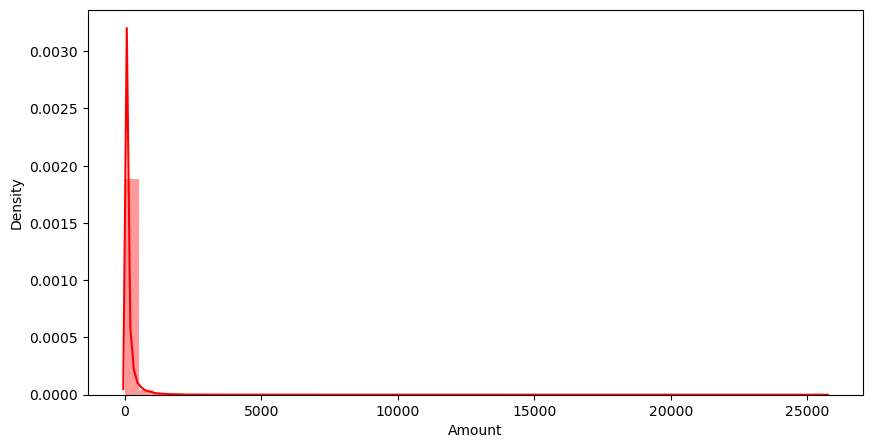

In [53]:
plt.figure(figsize=(10, 5))
sns.distplot(raw_data['Amount'], color='r')
plt.show()

- 컬럼의 분포가 특정 대역기 매우 많다.

### [1] Amount 컬럼에 StandardScaler 적용

In [54]:
raw_data['Amount']

0         149.62
1           2.69
2         378.66
3         123.50
4          69.99
           ...  
284802      0.77
284803     24.79
284804     67.88
284805     10.00
284806    217.00
Name: Amount, Length: 284807, dtype: float64

In [55]:
raw_data['Amount'].values

array([149.62,   2.69, 378.66, ...,  67.88,  10.  , 217.  ])

In [56]:
type(raw_data['Amount'].values)

numpy.ndarray

In [57]:
raw_data['Amount'].values.shape

(284807,)

In [58]:
raw_data['Amount'].values.reshape(-1, 1)

array([[149.62],
       [  2.69],
       [378.66],
       ...,
       [ 67.88],
       [ 10.  ],
       [217.  ]])

In [59]:
raw_data['Amount'].values.reshape(-1, 1).shape

(284807, 1)

In [60]:
raw_data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [61]:
from sklearn.preprocessing import StandardScaler

sd_scaler = StandardScaler()
amount_sd = sd_scaler.fit_transform(raw_data['Amount'].values.reshape(-1, 1))

raw_data_copy = raw_data.iloc[:, 1:-2]
raw_data_copy['Amount_Scaled'] = amount_sd
raw_data_copy.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount_Scaled
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,-0.073403


C:\Users\user\miniconda3\envs\ds_study\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


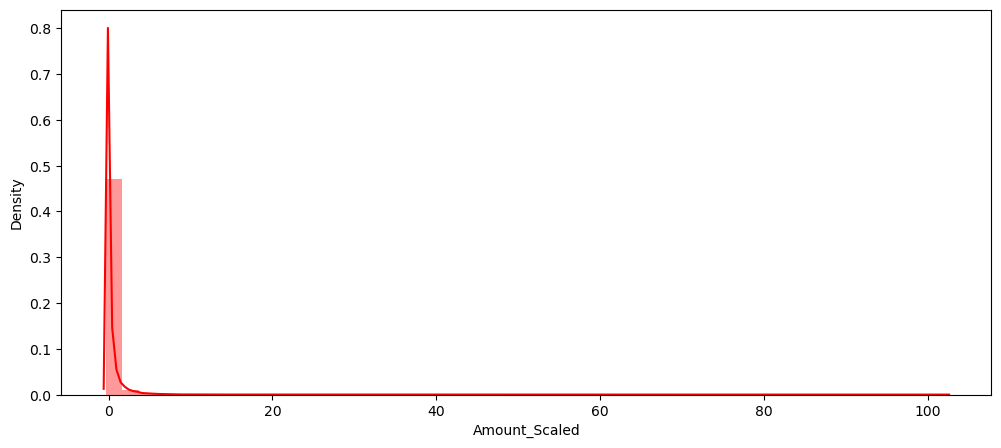

In [62]:
plt.figure(figsize=(12, 5))
sns.distplot(raw_data_copy['Amount_Scaled'], color='r')
plt.show()

### [2] 데이터 재분할

In [63]:
X_train, X_test, y_train, y_test = train_test_split(raw_data_copy, y, test_size=0.3, random_state=13, stratify=y)

---
### [3]  정리한 데이터 모델에 학습

In [64]:
%%time

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM']

res = get_res_pd(models, model_names, X_train, y_train, X_test, y_test)

res

CPU times: total: 7min 50s
Wall time: 2min 13s


,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.999169,0.888889,0.594595,0.712551,0.797233
DecisionTree,0.999345,0.883333,0.716216,0.791045,0.858026
RandomForest,0.999497,0.956522,0.743243,0.836502,0.871592
LightGBM,0.999520,0.949580,0.763514,0.846442,0.881722


- recall 에 큰 변화가 없음..

### [4] 모델별 ROC 커브

In [65]:
from sklearn.metrics import roc_curve

def draw_roc_curve(models, model_names, X_test, y_test):
    plt.figure(figsize=(10, 10))
    
    for m in range(len(models)):
        pred = models[m].predict_proba(X_test)[:, 1]  # roc 커브는 predict_proba 값으로 그린다.
        fpr, tpr, threshold = roc_curve(y_test, pred)
        plt.plot(fpr, tpr, label=model_names[m])
    
    plt.plot([0,1], [0,1], 'k--', label='random quess') # 대각선
    plt.title('ROC')
    plt.legend()
    plt.grid()
    plt.show()

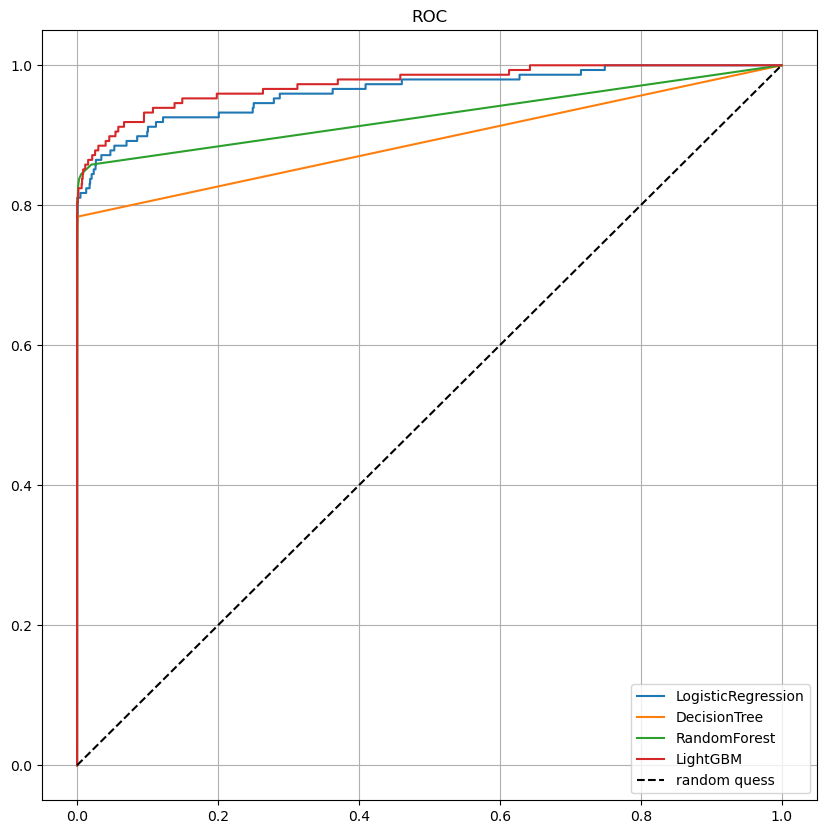

In [66]:
draw_roc_curve(models, model_names, X_test, y_test)

---
## (2) log scale 

### [1] scale 적용

In [67]:
amount_log = np.log1p(raw_data['Amount'])

raw_data_copy['Amount_Scaled'] = amount_log
raw_data_copy.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount_Scaled
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,5.014760
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,1.305626
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,5.939276
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,4.824306
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,4.262539


C:\Users\user\miniconda3\envs\ds_study\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


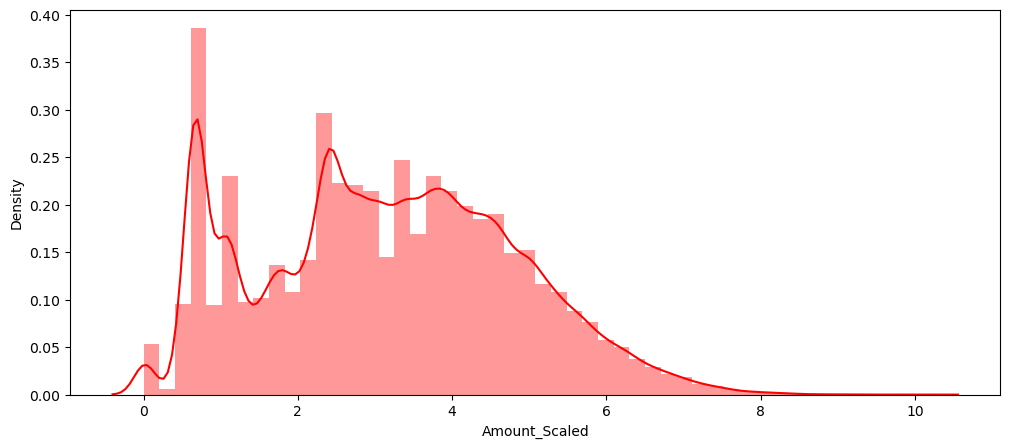

In [68]:
plt.figure(figsize=(12, 5))
sns.distplot(raw_data_copy['Amount_Scaled'], color='r')
plt.show()

- Amount 컬럼의 분포가 변함

### [2] 데이터 재분할

In [69]:
X_train, X_test, y_train, y_test = train_test_split(raw_data_copy, y, test_size=0.3, random_state=13, stratify=y)

### [3] 모델에 학습

In [70]:
%%time

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['LogisticRegression', 'DecisionTree', 'RandomForest', 'LightGBM']

res = get_res_pd(models, model_names, X_train, y_train, X_test, y_test)

res

CPU times: total: 7min 49s
Wall time: 2min 11s


,accuracy,precision,recall,f1,roc_auc
LogisticRegression,0.999157,0.887755,0.587838,0.707317,0.793854
DecisionTree,0.999345,0.883333,0.716216,0.791045,0.858026
RandomForest,0.999497,0.956522,0.743243,0.836502,0.871592
LightGBM,0.999532,0.950000,0.770270,0.850746,0.885100


- 큰 변화는 보이지 않는다.

### [4] ROC 커브

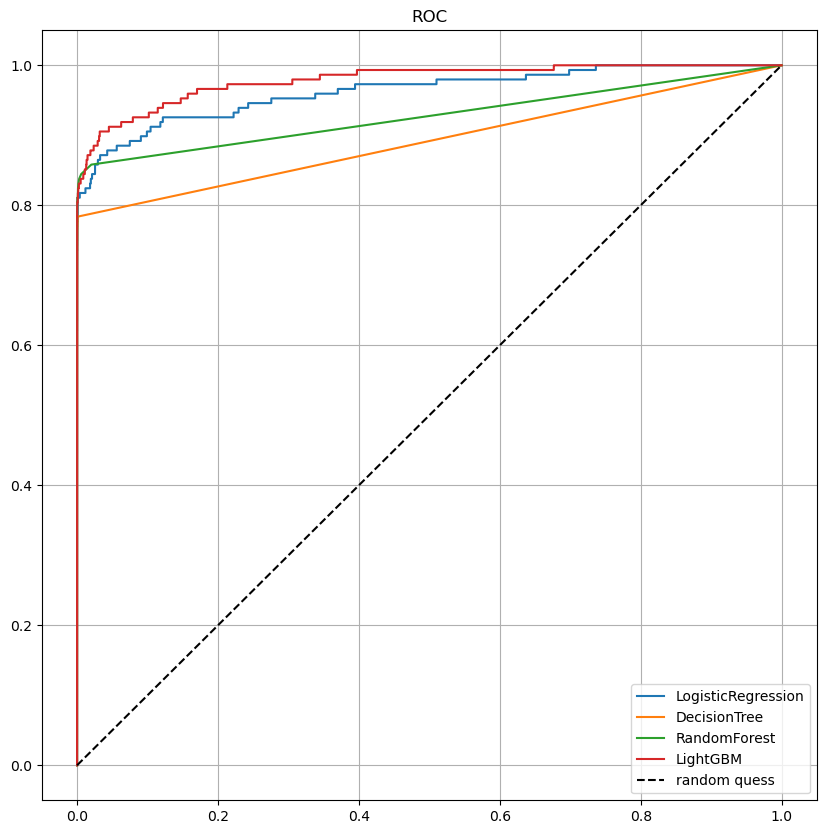

In [71]:
draw_roc_curve(models, model_names, X_test, y_test)

---
# 5. 세번째 시도 _ Outlier 정리

### (1) 이상점 찾기

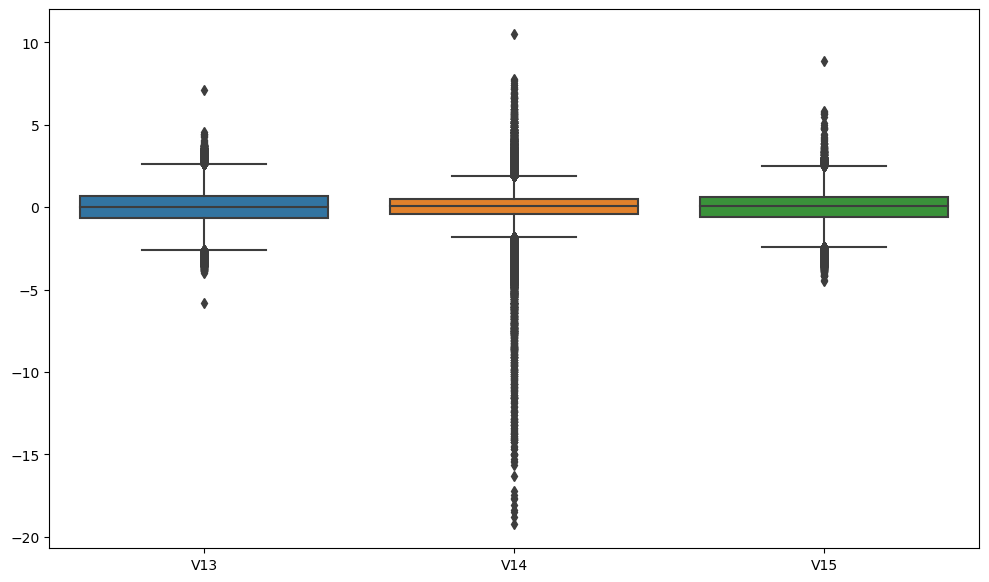

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
sns.boxplot(data=raw_data[['V13', 'V14', 'V15']])           ;

- V14 컬럼에 이상점 발견(아래쪽)

### (2) 이상점 정리

In [73]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    fraud = df[df['Class'] == 1][column]
    q_25 = np.percentile(fraud.values, 25)
    q_75 = np.percentile(fraud.values, 75)
    
    iqr = q_75 - q_25
    iqr_weight = iqr * weight
    lowet_val = q_25 - iqr_weight
    highest_val = q_75 + iqr_weight
    
    outlier_index = fraud[(fraud < lowet_val) | (fraud > highest_val)].index  # | : OR
    
    return outlier_index

In [74]:
# 이상점 찾기
get_outlier(df=raw_data, column='V14', weight=1.5)

Int64Index([8296, 8615, 9035, 9252], dtype='int64')

- 이상점 4개 발견

### (3) 이상점 제거

In [75]:
raw_data_copy.shape

(284807, 29)

In [76]:
outlier_index = get_outlier(df=raw_data, column='V14', weight=1.5)
raw_data_copy.drop(outlier_index, axis=0, inplace=True)  #  axis=0 : 행 방향으로 삭제
raw_data_copy.shape

(284803, 29)

### (4) 데이터 나누기

In [77]:
# raw_data_copy : 스케일러 적용 함 / y값('Amount') 없음
# raw_data : 스케일러 적용 안함

X = raw_data_copy

raw_data.drop(outlier_index, axis=0, inplace=True)
y = raw_data.iloc[:, -1]

X_train,X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13, stratify=y)

In [78]:
%%time

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['Rogistic Regression', 'Decision Tree', 'Random Forest', 'LightGBM']

res = get_res_pd(models, model_names, X_train, y_train, X_test, y_test)

res

CPU times: total: 7min 33s
Wall time: 2min 6s


,accuracy,precision,recall,f1,roc_auc
Rogistic Regression,0.999286,0.904762,0.650685,0.756972,0.825284
Decision Tree,0.999427,0.870229,0.780822,0.823105,0.890311
Random Forest,0.999497,0.918699,0.773973,0.840149,0.886928
LightGBM,0.999602,0.951613,0.808219,0.874074,0.904074


- LightGBM의 recall값이 조금 좋아졌다!

### (5) ROC 그래프

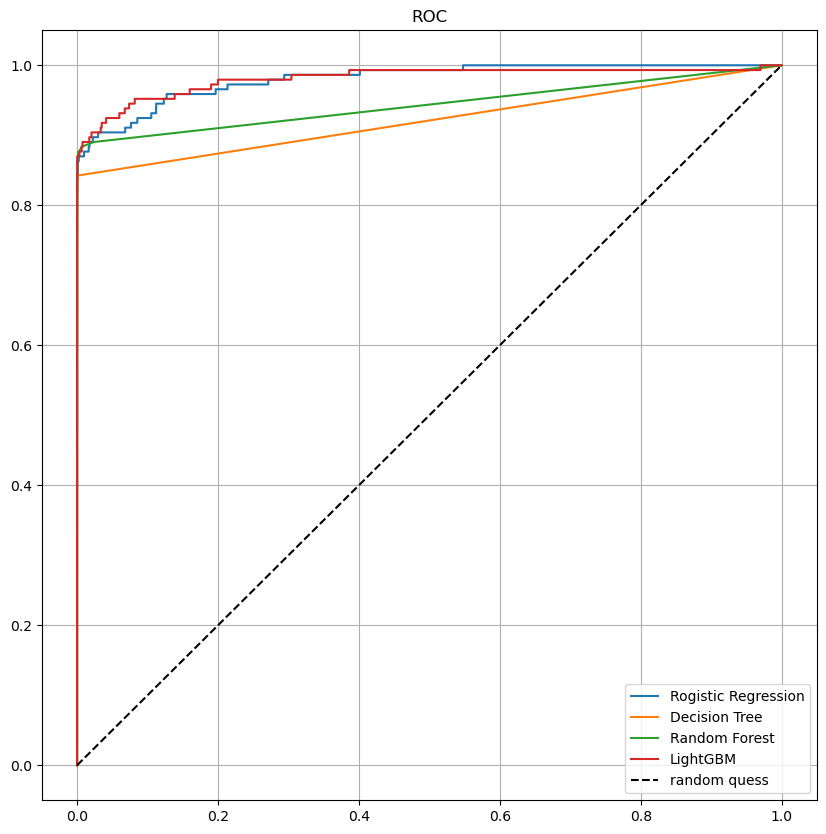

In [79]:
draw_roc_curve(models, model_names, X_test, y_test)

---
# 6. 네번째 시도 _ OverSampling
- 데이터의 불균형이 심할 때 두 클래스의 분포를 강제로 맞춰보는 작업
- 원본데이터의 피처 값들을 아주 약간 변경하여 증식
- 대툐적으로 SMOTE(Synthetic Minority Over-sampling Technique) 방법이 존대
- 적은 데이터셍에 있는 개별 데이터를 K-최근접이웃 방법으로 찾아서 데이터의 분포 사이에 새로운 데이터를 만드는 방식
- imbalanced-learn 이라는 Python pkg가 존재



- 반) Under Sampling : 많은 수의 데이터를 적은 수의 데이터로 강제로 조정

In [80]:
#!pip install imbalanced-learn

### (1) SMOTE 적용

In [81]:
from imblearn.over_sampling import SMOTE

In [82]:
smote = SMOTE(random_state=13)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)   # test는 건들지 말기!

In [83]:
X_train.shape, y_train.shape

((199362, 29), (199362,))

In [84]:
X_train_over.shape, y_train_over.shape

((398040, 29), (398040,))

In [85]:
print(np.unique(y_train, return_counts=True))

(array([0, 1], dtype=int64), array([199020,    342], dtype=int64))


In [86]:
print(np.unique(y_train_over, return_counts=True))

(array([0, 1], dtype=int64), array([199020, 199020], dtype=int64))


In [88]:
%%time

models = [lr_clf, dt_clf, rf_clf, lgbm_clf]
model_names = ['Rogistic Regression', 'Decision Tree', 'Random Forest', 'LightGBM']

res = get_res_pd(models, model_names, X_train_over, y_train_over, X_test, y_test)

res

CPU times: total: 14min 55s
Wall time: 4min 18s


,accuracy,precision,recall,f1,roc_auc
Rogistic Regression,0.975609,0.059545,0.897260,0.111679,0.936502
Decision Tree,0.968984,0.046048,0.869863,0.087466,0.919509
Random Forest,0.999532,0.873239,0.849315,0.861111,0.924552
LightGBM,0.999532,0.873239,0.849315,0.861111,0.924552


- recall 이 확실히 좋아졌다.

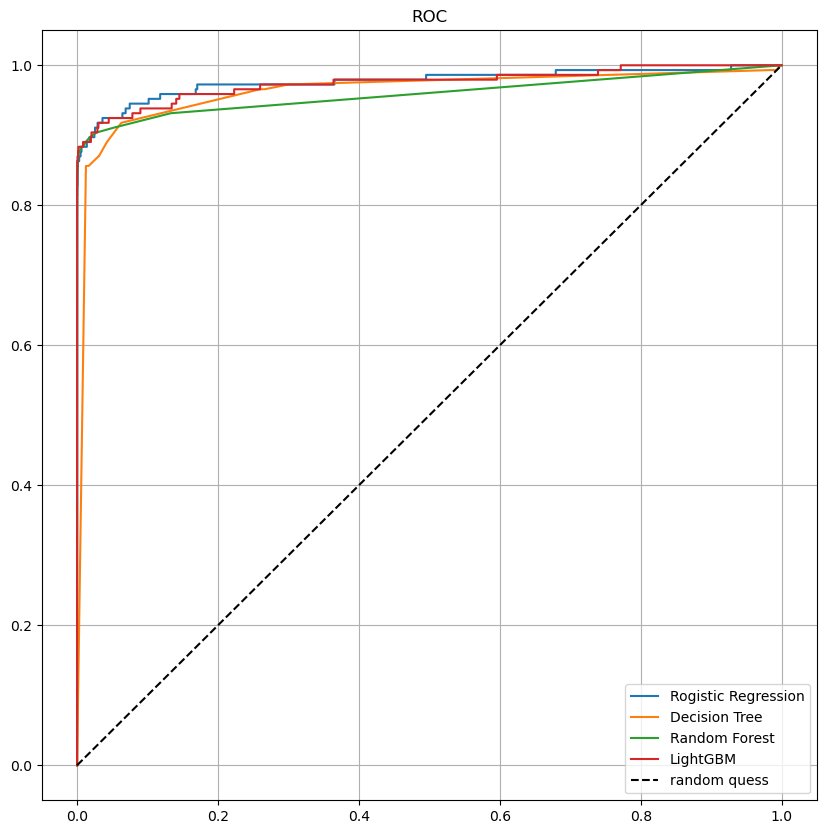

In [89]:
draw_roc_curve(models, model_names, X_test, y_test)